<a href="https://colab.research.google.com/github/khushigituser/CODTECH-Task1/blob/main/Stock_Trading_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install gymnasium gym-anytrading stable-baselines3


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# Import required packages
# Note that gym-anytrading is a gym environment specific for trading
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gymnasium as gym
import gym_anytrading
from gym_anytrading.envs import Actions
from stable_baselines3 import PPO



In [ ]:
# Load the data provided
data = pd.read_csv("AAPL.csv", parse_dates=True, index_col='Date')


In [ ]:
# Set window size (lookback window), start and end index of data
window_size = 10
start_index = window_size
end_index = len(data)

In [ ]:
# Create the environment using the pre-built 'stocks-v0', passing in the data loaded above
# window_size is how far the environment can look back at each step
# frame_bound is the bounding box of the environment, the size of our data
env = gym.make('stocks-v0', df=data, window_size=window_size, frame_bound=(start_index, end_index))
print("Observation Space:", env.observation_space)

Observation Space: Box(-10000000000.0, 10000000000.0, (10, 2), float32)


In [ ]:
# Initialise cash balance tracking and other variables
balance = 100000
balance_history = [balance]
shares_held = 0
action_stats = {Actions.Sell: 0, Actions.Buy: 0}
observation, info = env.reset(seed=2024)


In [ ]:
# Create a PPO model using MlpPolicy, our environment, and set verbose to 0
model = PPO("MlpPolicy", env, verbose=0)

In [ ]:
# Train the model for a specified number of timesteps
model.learn(total_timesteps=10000)

In [ ]:
# Initialize necessary variables
step = 0
while True:
    # Predict the action to take using the trained model
    action, _states = model.predict(observation)

    # Get the current price from the environment
    current_price = env.unwrapped.prices[env.unwrapped._current_tick]

    # Take the action in the environment
    observation, reward, terminated, truncated, info = env.step(action)

    trade_amount = balance * 0.10  # Trade with 10% of current balance

    if action == Actions.Buy.value:
        shares_to_buy = trade_amount / current_price
        shares_held += shares_to_buy
        balance -= trade_amount
        print(f"{step}: BUY  {shares_to_buy:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
    elif action == Actions.Sell.value and shares_held > 0:
        balance += shares_held * current_price
        print(f"{step}: SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
        shares_held = 0
    else:
      print(f"{step}: HOLD | Current price: ${current_price:.2f} | Balance: ${balance:.2f}")

    action_stats[Actions(action)] += 1
    balance_history.append(balance)

    step += 1
    if terminated or truncated:
        break
        # If we still hold shares at the end, sell them all
if shares_held > 0:
    balance += shares_held * current_price
    print(f"\nFinal SELL {shares_held:.2f} shares at ${current_price:.2f} | Balance: ${balance:.2f}")
    shares_held = 0

env.close()

print("Action stats:", action_stats)
print(f"Final Balance: ${balance:.2f}")

0: HOLD | Current price: $74.39 | Balance: $100000.00
1: BUY  133.05 shares at $75.16 | Balance: $90000.00
2: BUY  118.52 shares at $75.93 | Balance: $81000.00
3: SELL 251.58 shares at $77.53 | Balance: $100505.34
4: HOLD | Current price: $78.75 | Balance: $100505.34
5: HOLD | Current price: $77.85 | Balance: $100505.34
6: BUY  130.67 shares at $76.91 | Balance: $90454.81
7: SELL 130.67 shares at $77.39 | Balance: $100567.09
8: HOLD | Current price: $76.93 | Balance: $100567.09
9: BUY  127.72 shares at $78.74 | Balance: $90510.38
10: BUY  115.62 shares at $78.29 | Balance: $81459.34
11: SELL 243.34 shares at $79.81 | Balance: $100879.46
12: BUY  127.35 shares at $79.21 | Balance: $90791.51
13: BUY  113.88 shares at $79.72 | Balance: $81712.36
14: SELL 241.24 shares at $79.18 | Balance: $100814.14
15: BUY  126.77 shares at $79.53 | Balance: $90732.72
16: SELL 126.77 shares at $79.56 | Balance: $100818.57
17: BUY  126.84 shares at $79.49 | Balance: $90736.72
18: SELL 126.84 shares at $80

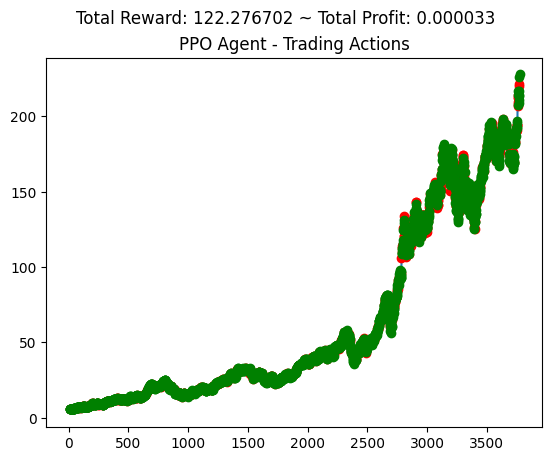

In [ ]:
# Create your two charts below. Note, do not change the fig and ax variable names.

# Chart 1, a plot showing trading actions
fig, ax = plt.subplots()
env.unwrapped.render_all()
ax.set_title("PPO Agent - Trading Actions")
plt.show()




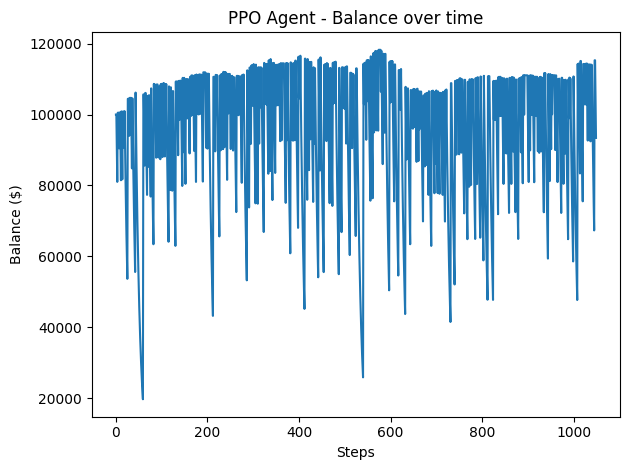

In [ ]:
# Chart 2, a plot of the balance_history over time
fig2, ax2 = plt.subplots()
ax2.plot(balance_history)
ax2.set_title("PPO Agent - Balance over time")
ax2.set_xlabel("Steps")
ax2.set_ylabel("Balance ($)")

fig2.tight_layout()
plt.show()